<a href="https://colab.research.google.com/github/tz15/CitadelDatathon/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For training in colab 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/Colab Notebooks/Citadel/data

/content/drive/My Drive/Colab Notebooks/Citadel/data


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

pd.set_option('display.max_rows', None)

## Preparing Data

#### Loading the data

In [ ]:
country = pd.read_csv("country.csv")
league = pd.read_csv("league.csv")
match = pd.read_csv("match.csv")
player = pd.read_csv("player.csv")
player_attributes = pd.read_csv("player_attributes.csv")
team = pd.read_csv("team.csv", encoding='latin1')
team_attributes = pd.read_csv("team_attributes.csv")

#### Clean Date 

In [ ]:
match["date"] = match["date"].apply(lambda s: datetime.strptime(s, '%m/%d/%y %H:%M'))
player_attributes["date"] = player_attributes["date"].apply(lambda s: datetime.strptime(s, '%m/%d/%y %H:%M'))
team_attributes["date"] = team_attributes["date"].apply(lambda s: datetime.strptime(s, '%m/%d/%y %H:%M'))

#### Clean Duplicate Records

In [ ]:
match.drop_duplicates(subset=["match_id", "date"], inplace=True)
player_attributes.drop_duplicates(subset=["player_id", "date"], inplace=True)
team_attributes.drop_duplicates(subset=["team_id", "date"], inplace=True)

#### Join contry and league with team

In [ ]:
match = match.join(country.rename(columns = {"name":"country_name"}).set_index("country_id"), 
                   on = "country_id", how = "left")
match = match.join(league[["league_id","name"]].rename(columns = {"name":"league_name"}).set_index("league_id"), 
                   on = "league_id", how = "left")

#### Join Home and Away Team with Match

In [ ]:
match_team = match.join(team.set_index("team_id").rename(columns = {"team_long_name":"home_team_long_name",
                                                                    "team_short_name":"home_team_short_name"}),
                        on="home_team_id", how = "left")
match_team = match_team.join(team.set_index("team_id").rename(columns = {"team_long_name":"away_team_long_name",
                                                                         "team_short_name":"away_team_short_name"}),
                             on="away_team_id", how = "left")

#### Join Home and Away Team Attributes with Match
Note: 
1. Overall, the match the the most recently updated team attributes record. 
2. if the team has no attributes in history, it will be NA. 
3. if the match happened before the first team attributes record, it will get data from the first record.

In [ ]:
NOW_DAY = datetime(2021, 3, 23)

In [ ]:
# Join Home and Away Team with Match
team_attributes["next"] = team_attributes.groupby(['team_id'])["date"].rank() -1
team_attributes["now"] = team_attributes.groupby(['team_id'])["date"].rank()

In [ ]:
team_attributes_with_interval = team_attributes.merge(team_attributes[["team_id","next","date"]], 
                                                      left_on=["team_id","now"], 
                                                      right_on=["team_id","next"],
                                                      how = "left",
                                                      suffixes = ["", "_next"])

In [ ]:
team_attributes_with_interval["date_next"].fillna(NOW_DAY, inplace = True)
team_attributes_with_interval.drop(["next",  "next_next"], axis = 1, inplace= True)
# team_attributes_with_interval.head()

In [ ]:
# For home team attributes
match_team_and_attrs = match_team.merge(team_attributes_with_interval, 
                                        how="left",
                                        left_on = "home_team_id",
                                        right_on = "team_id",
                                        suffixes = ["", "_home_team"])
match_team_and_attrs = match_team_and_attrs[((match_team_and_attrs['date'] < match_team_and_attrs['date_next']) \
                                             & (match_team_and_attrs['date'] >= match_team_and_attrs['date_home_team'])) \
                                            |(match_team_and_attrs['date_home_team'].isnull()) \
                                            |((match_team_and_attrs['date'] < match_team_and_attrs['date_home_team']) \
                                             & (match_team_and_attrs['now'] == 1))  ]
match_team_and_attrs.drop(["team_id","now", "date_next"], axis = 1, inplace= True)                           

In [ ]:
# For away team attributes
match_team_and_attrs = match_team_and_attrs.merge(team_attributes_with_interval, 
                                                  how="left",
                                                  left_on = "away_team_id",
                                                  right_on = "team_id",
                                                  suffixes = ["", "_away_team"])
match_team_and_attrs = match_team_and_attrs[((match_team_and_attrs['date'] < match_team_and_attrs['date_next']) \
                                             & (match_team_and_attrs['date'] >= match_team_and_attrs['date_away_team'])) \
                                            |(match_team_and_attrs['date_away_team'].isnull()) \
                                            |((match_team_and_attrs['date'] < match_team_and_attrs['date_away_team']) \
                                             & (match_team_and_attrs['now'] == 1))  ]
match_team_and_attrs.drop(["team_id","now", "date_next"], axis = 1, inplace= True)                                                 

#### Add more match related features

For the classification problem, we define a Home Win has label 2, Draw has label 1, and Home Loss has label 0, This choice is arbitrary.

In [ ]:
match_team_and_attrs["home_win"] = np.sign(match_team_and_attrs["home_team_goal"] - match_team_and_attrs["away_team_goal"])
match_team_and_attrs["home_win"] = match_team_and_attrs["home_win"].map({1:2,0:1,-1:0})

In [ ]:
match_team_and_attrs["home_points"] = match_team_and_attrs["home_win"].map({1:3,0:1,-1:0})

#### Try to handel players

In [ ]:
match_team_and_attrs.columns

Index(['country_id', 'league_id', 'season', 'stage', 'date', 'match_id',
       'home_team_id', 'away_team_id', 'home_team_goal', 'away_team_goal',
       ...
       'chanceCreationPositioningClass_away_team', 'defencePressure_away_team',
       'defencePressureClass_away_team', 'defenceAggression_away_team',
       'defenceAggressionClass_away_team', 'defenceTeamWidth_away_team',
       'defenceTeamWidthClass_away_team', 'defenceDefenderLineClass_away_team',
       'home_win', 'home_points'],
      dtype='object', length=114)

## EDA

In [ ]:
# match_team_and_attrs.count()

In [ ]:
match_team_and_attrs.head()

,country_id,league_id,season,stage,date,match_id,home_team_id,away_team_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,...,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,date_away_team,buildUpPlaySpeed_away_team,buildUpPlaySpeedClass_away_team,buildUpPlayDribbling_away_team,buildUpPlayDribblingClass_away_team,buildUpPlayPassing_away_team,buildUpPlayPassingClass_away_team,buildUpPlayPositioningClass_away_team,chanceCreationPassing_away_team,chanceCreationPassingClass_away_team,chanceCreationCrossing_away_team,chanceCreationCrossingClass_away_team,chanceCreationShooting_away_team,chanceCreationShootingClass_away_team,chanceCreationPositioningClass_away_team,defencePressure_away_team,defencePressureClass_away_team,defenceAggression_away_team,defenceAggressionClass_away_team,defenceTeamWidth_away_team,defenceTeamWidthClass_away_team,defenceDefenderLineClass_away_team,home_win,home_points
0,1,1,2008/2009,1,2008-08-17,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,...,Mixed,Organised,50.0,Normal,35.0,Normal,60.0,Normal,Organised,70.0,High,65.0,Press,70.0,Wide,Cover,2010-02-22,35.0,Balanced,NaN,Little,35.0,Mixed,Organised,45.0,Normal,40.0,Normal,50.0,Normal,Organised,70.0,High,70.0,Double,70.0,Wide,Cover,1,3.0
4,1,1,2008/2009,1,2008-08-16,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,...,Mixed,Organised,60.0,Normal,40.0,Normal,50.0,Normal,Organised,70.0,High,60.0,Press,70.0,Wide,Cover,2010-02-22,60.0,Balanced,NaN,Little,60.0,Mixed,Organised,50.0,Normal,40.0,Normal,50.0,Normal,Organised,65.0,Medium,65.0,Press,70.0,Wide,Cover,1,3.0
10,1,1,2008/2009,1,2008-08-16,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,...,Mixed,Organised,70.0,Risky,45.0,Normal,55.0,Normal,Organised,65.0,Medium,60.0,Press,70.0,Wide,Cover,2010-02-22,50.0,Balanced,NaN,Little,35.0,Mixed,Organised,70.0,Risky,50.0,Normal,60.0,Normal,Organised,70.0,High,50.0,Press,70.0,Wide,Cover,0,1.0
16,1,1,2008/2009,1,2008-08-17,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,...,Mixed,Organised,60.0,Normal,50.0,Normal,60.0,Normal,Organised,45.0,Medium,50.0,Press,40.0,Normal,Cover,2012-02-22,50.0,Balanced,NaN,Little,50.0,Mixed,Organised,55.0,Normal,48.0,Normal,46.0,Normal,Organised,46.0,Medium,45.0,Press,47.0,Normal,Cover,2,NaN
19,1,1,2008/2009,1,2008-08-16,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-02-22,53.0,Balanced,NaN,Little,40.0,Mixed,Organised,55.0,Normal,55.0,Normal,65.0,Normal,Organised,70.0,High,70.0,Double,65.0,Normal,Cover,0,1.0


In [ ]:
match_team_and_attrs.drop(match_team_and_attrs.loc[:,'home_player_1':'away_player_11'],axis=1,inplace=True)
match_team_and_attrs.head()

,country_id,league_id,season,stage,date,match_id,home_team_id,away_team_id,home_team_goal,away_team_goal,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,...,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,date_away_team,buildUpPlaySpeed_away_team,buildUpPlaySpeedClass_away_team,buildUpPlayDribbling_away_team,buildUpPlayDribblingClass_away_team,buildUpPlayPassing_away_team,buildUpPlayPassingClass_away_team,buildUpPlayPositioningClass_away_team,chanceCreationPassing_away_team,chanceCreationPassingClass_away_team,chanceCreationCrossing_away_team,chanceCreationCrossingClass_away_team,chanceCreationShooting_away_team,chanceCreationShootingClass_away_team,chanceCreationPositioningClass_away_team,defencePressure_away_team,defencePressureClass_away_team,defenceAggression_away_team,defenceAggressionClass_away_team,defenceTeamWidth_away_team,defenceTeamWidthClass_away_team,defenceDefenderLineClass_away_team,home_win,home_points
0,1,1,2008/2009,1,2008-08-17,492473,9987,9993,1,1,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20,...,Mixed,Organised,50.0,Normal,35.0,Normal,60.0,Normal,Organised,70.0,High,65.0,Press,70.0,Wide,Cover,2010-02-22,35.0,Balanced,NaN,Little,35.0,Mixed,Organised,45.0,Normal,40.0,Normal,50.0,Normal,Organised,70.0,High,70.0,Double,70.0,Wide,Cover,1,3.0
4,1,1,2008/2009,1,2008-08-16,492474,10000,9994,0,0,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60,...,Mixed,Organised,60.0,Normal,40.0,Normal,50.0,Normal,Organised,70.0,High,60.0,Press,70.0,Wide,Cover,2010-02-22,60.0,Balanced,NaN,Little,60.0,Mixed,Organised,50.0,Normal,40.0,Normal,50.0,Normal,Organised,65.0,Medium,65.0,Press,70.0,Wide,Cover,1,3.0
10,1,1,2008/2009,1,2008-08-16,492475,9984,8635,0,3,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75,...,Mixed,Organised,70.0,Risky,45.0,Normal,55.0,Normal,Organised,65.0,Medium,60.0,Press,70.0,Wide,Cover,2010-02-22,50.0,Balanced,NaN,Little,35.0,Mixed,Organised,70.0,Risky,50.0,Normal,60.0,Normal,Organised,70.0,High,50.0,Press,70.0,Wide,Cover,0,1.0
16,1,1,2008/2009,1,2008-08-17,492476,9991,9998,5,0,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50,...,Mixed,Organised,60.0,Normal,50.0,Normal,60.0,Normal,Organised,45.0,Medium,50.0,Press,40.0,Normal,Cover,2012-02-22,50.0,Balanced,NaN,Little,50.0,Mixed,Organised,55.0,Normal,48.0,Normal,46.0,Normal,Organised,46.0,Medium,45.0,Press,47.0,Normal,Cover,2,NaN
19,1,1,2008/2009,1,2008-08-16,492477,7947,9985,1,3,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-02-22,53.0,Balanced,NaN,Little,40.0,Mixed,Organised,55.0,Normal,55.0,Normal,65.0,Normal,Organised,70.0,High,70.0,Double,65.0,Normal,Cover,0,1.0


In [ ]:
match_team_and_attrs.columns

Index(['country_id', 'league_id', 'season', 'stage', 'date', 'match_id',
       'home_team_id', 'away_team_id', 'home_team_goal', 'away_team_goal',
       'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA',
       'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH',
       'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD',
       'BSA', 'country_name', 'league_name', 'home_team_long_name',
       'home_team_short_name', 'away_team_long_name', 'away_team_short_name',
       'date_home_team', 'buildUpPlaySpeed', 'buildUpPlaySpeedClass',
       'buildUpPlayDribbling', 'buildUpPlayDribblingClass',
       'buildUpPlayPassing', 'buildUpPlayPassingClass',
       'buildUpPlayPositioningClass', 'chanceCreationPassing',
       'chanceCreationPassingClass', 'chanceCreationCrossing',
       'chanceCreationCrossingClass', 'chanceCreationShooting',
       'chanceCreationShootingClass', 'chanceCreationPositioningClass',
       'defencePressure', 'd

In [ ]:
match_team_and_attrs.shape

(25979, 92)

In [ ]:
match_team_and_attrs.isna().sum()

country_id                                      0
league_id                                       0
season                                          0
stage                                           0
date                                            0
match_id                                        0
home_team_id                                    0
away_team_id                                    0
home_team_goal                                  0
away_team_goal                                  0
B365H                                        3387
B365D                                        3387
B365A                                        3387
BWH                                          3404
BWD                                          3404
BWA                                          3404
IWH                                          3459
IWD                                          3459
IWA                                          3459
LBH                                          3423


Defining the columns corresponding to mean bookmakers bets on home wins, away wins and draws


In [ ]:
home=['B365H','BWH','IWH','LBH','PSH','WHH','SJH','VCH','GBH','BSH']
away=['B365A','BWA','IWA','LBA','PSA','WHA','SJA','VCA','GBA','BSA']
draw=['B365D','BWD','IWD','LBD','PSD','WHD','SJD','VCD','GBD','BSD']
match_team_and_attrs['MBOH']=match_team_and_attrs[home].mean(axis=1)
match_team_and_attrs['MBOA']=match_team_and_attrs[away].mean(axis=1)
match_team_and_attrs['MBOD']=match_team_and_attrs[draw].mean(axis=1)


Drop 2 columns where more than a half values is nan

In [ ]:
match_team_and_attrs.drop(['buildUpPlayDribbling','buildUpPlayDribbling_away_team'],axis=1,inplace=True)

In [ ]:
match_team_and_attrs["league_name"].unique()

array(['Belgium Jupiler League', 'England Premier League',
       'France Ligue 1', 'Germany 1. Bundesliga', 'Italy Serie A',
       'Netherlands Eredivisie', 'Poland Ekstraklasa',
       'Portugal Liga ZON Sagres', 'Scotland Premier League',
       'Spain LIGA BBVA', 'Switzerland Super League'], dtype=object)

In [ ]:
match_team_and_attrs["season"].unique()

array(['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013',
       '2013/2014', '2014/2015', '2015/2016'], dtype=object)

In [ ]:
def match_outcome_agg(x):
    names = {
        'home_points_total' : x['home_points'].sum(),
        'home_win_net': x['home_win'].sum(),
        'home_team_goal_sum':  x['home_team_goal'].mean(),
        'away_team_goal_sum': x['away_team_goal'].mean()}

    return pd.Series(names, index=["home_points_total", "home_win_net", "home_team_goal_sum", "away_team_goal_sum"])

In [ ]:
match_team_and_attrs[(match_team_and_attrs["league_name"]=="England Premier League") \
                     & (match_team_and_attrs["season"]=="2015/2016")]\
                     .groupby("home_team_long_name") \
                     .apply(match_outcome_agg) \
                     .sort_values("home_points_total", ascending = False)

,home_points_total,home_win_net,home_team_goal_sum,away_team_goal_sum
home_team_long_name,,,,
Chelsea,32.0,19.0,1.684211,1.578947
Liverpool,27.0,24.0,1.736842,1.157895
Aston Villa,27.0,9.0,0.736842,1.842105
Newcastle United,26.0,21.0,1.684211,1.263158
Watford,25.0,18.0,1.052632,1.000000
Sunderland,25.0,18.0,1.210526,1.052632
West Ham United,24.0,25.0,1.789474,1.368421
Bournemouth,24.0,15.0,1.210526,1.789474
Everton,23.0,17.0,1.842105,1.578947


In [ ]:
match_team[match_team["match_id"] == 492488]

,country_id,league_id,season,stage,date,match_id,home_team_id,away_team_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,country_name,league_name,home_team_long_name,home_team_short_name,away_team_long_name,away_team_short_name
105,1,1,2008/2009,2,2008-08-23,492488,9996,8203,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.05,3.3,3.4,2.05,3.2,3.2,2.1,3.1,3.0,1.91,3.4,3.25,NaN,NaN,NaN,2.0,3.3,3.1,1.95,3.4,3.6,2.0,3.25,3.25,2.0,3.2,3.3,2.0,3.25,3.3,Belgium,Belgium Jupiler League,Royal Excel Mouscron,MOU,KV Mechelen,MEC


In [ ]:
team_attributes_with_interval[team_attributes_with_interval["team_id"] == 9996]

,team_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,now,date_next
859,9996,2015-09-10,50,Balanced,50.0,Normal,50,Mixed,Organised,50,Normal,50,Normal,50,Normal,Organised,45,Medium,45,Press,50,Normal,Cover,1.0,2021-03-23


### Are there relations between play type and match outcome?

TODO:
Create win column (whats larger home or away goals) (done)

Select subset of games (assume one league)

Heatmap of attributes to win ratio 



Create Winner Column so we can easily check

In [ ]:
match_team_and_attrs['winner']=""
for i, row in match_team_and_attrs.iterrows():
  homegoals = float(row["home_team_goal"])
  awaygoals = float(row['away_team_goal'])
  if homegoals > awaygoals:
    match_team_and_attrs.at[i,'winner'] = row['home_team_id']
  elif awaygoals > homegoals:
    match_team_and_attrs.at[i,'winner'] = row['away_team_id']
  else:
    match_team_and_attrs.at[i,'winner'] = 0

In [ ]:
match_team_and_attrs.head()

,country_id,league_id,season,stage,date,match_id,home_team_id,away_team_id,home_team_goal,away_team_goal,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,...,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,date_away_team,buildUpPlaySpeed_away_team,buildUpPlaySpeedClass_away_team,buildUpPlayDribblingClass_away_team,buildUpPlayPassing_away_team,buildUpPlayPassingClass_away_team,buildUpPlayPositioningClass_away_team,chanceCreationPassing_away_team,chanceCreationPassingClass_away_team,chanceCreationCrossing_away_team,chanceCreationCrossingClass_away_team,chanceCreationShooting_away_team,chanceCreationShootingClass_away_team,chanceCreationPositioningClass_away_team,defencePressure_away_team,defencePressureClass_away_team,defenceAggression_away_team,defenceAggressionClass_away_team,defenceTeamWidth_away_team,defenceTeamWidthClass_away_team,defenceDefenderLineClass_away_team,home_win,home_points,MBOH,MBOA,MBOD,winner
0,1,1,2008/2009,1,2008-08-17,492473,9987,9993,1,1,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20,...,Normal,35.0,Normal,60.0,Normal,Organised,70.0,High,65.0,Press,70.0,Wide,Cover,2010-02-22,35.0,Balanced,Little,35.0,Mixed,Organised,45.0,Normal,40.0,Normal,50.0,Normal,Organised,70.0,High,70.0,Double,70.0,Wide,Cover,1,3.0,1.765556,4.164444,3.322222,0
4,1,1,2008/2009,1,2008-08-16,492474,10000,9994,0,0,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60,...,Normal,40.0,Normal,50.0,Normal,Organised,70.0,High,60.0,Press,70.0,Wide,Cover,2010-02-22,60.0,Balanced,Little,60.0,Mixed,Organised,50.0,Normal,40.0,Normal,50.0,Normal,Organised,65.0,Medium,65.0,Press,70.0,Wide,Cover,1,3.0,1.898889,3.616667,3.250000,0
10,1,1,2008/2009,1,2008-08-16,492475,9984,8635,0,3,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75,...,Risky,45.0,Normal,55.0,Normal,Organised,65.0,Medium,60.0,Press,70.0,Wide,Cover,2010-02-22,50.0,Balanced,Little,35.0,Mixed,Organised,70.0,Risky,50.0,Normal,60.0,Normal,Organised,70.0,High,50.0,Press,70.0,Wide,Cover,0,1.0,2.462222,2.544444,3.233333,8635
16,1,1,2008/2009,1,2008-08-17,492476,9991,9998,5,0,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50,...,Normal,50.0,Normal,60.0,Normal,Organised,45.0,Medium,50.0,Press,40.0,Normal,Cover,2012-02-22,50.0,Balanced,Little,50.0,Mixed,Organised,55.0,Normal,48.0,Normal,46.0,Normal,Organised,46.0,Medium,45.0,Press,47.0,Normal,Cover,2,NaN,1.438889,6.533333,3.805556,9991
19,1,1,2008/2009,1,2008-08-16,492477,7947,9985,1,3,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-02-22,53.0,Balanced,Little,40.0,Mixed,Organised,55.0,Normal,55.0,Normal,65.0,Normal,Organised,70.0,High,70.0,Double,65.0,Normal,Cover,0,1.0,4.494444,1.674444,3.422222,9985


In [ ]:
teamclasses = ['buildUpPlaySpeed', 'buildUpPlaySpeedClass',
       'buildUpPlayDribblingClass', 'buildUpPlayPassing',
       'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
       'chanceCreationPassing', 'chanceCreationPassingClass',
       'chanceCreationCrossing', 'chanceCreationCrossingClass',
       'chanceCreationShooting', 'chanceCreationShootingClass',
       'chanceCreationPositioningClass', 'defencePressure',
       'defencePressureClass', 'defenceAggression', 'defenceAggressionClass',
       'defenceTeamWidth', 'defenceTeamWidthClass', 'defenceDefenderLineClass',
       'date_away_team', 'buildUpPlaySpeed_away_team',
       'buildUpPlaySpeedClass_away_team',
       'buildUpPlayDribblingClass_away_team', 'buildUpPlayPassing_away_team',
       'buildUpPlayPassingClass_away_team',
       'buildUpPlayPositioningClass_away_team',
       'chanceCreationPassing_away_team',
       'chanceCreationPassingClass_away_team',
       'chanceCreationCrossing_away_team',
       'chanceCreationCrossingClass_away_team',
       'chanceCreationShooting_away_team',
       'chanceCreationShootingClass_away_team',
       'chanceCreationPositioningClass_away_team', 'defencePressure_away_team',
       'defencePressureClass_away_team', 'defenceAggression_away_team',
       'defenceAggressionClass_away_team', 'defenceTeamWidth_away_team',
       'defenceTeamWidthClass_away_team', 'defenceDefenderLineClass_away_team']

In [ ]:
match_team_and_attrs.reset_index(drop=True, inplace=True)
match_team_and_attrs.head()

,country_id,league_id,season,stage,date,match_id,home_team_id,away_team_id,home_team_goal,away_team_goal,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,...,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,date_away_team,buildUpPlaySpeed_away_team,buildUpPlaySpeedClass_away_team,buildUpPlayDribblingClass_away_team,buildUpPlayPassing_away_team,buildUpPlayPassingClass_away_team,buildUpPlayPositioningClass_away_team,chanceCreationPassing_away_team,chanceCreationPassingClass_away_team,chanceCreationCrossing_away_team,chanceCreationCrossingClass_away_team,chanceCreationShooting_away_team,chanceCreationShootingClass_away_team,chanceCreationPositioningClass_away_team,defencePressure_away_team,defencePressureClass_away_team,defenceAggression_away_team,defenceAggressionClass_away_team,defenceTeamWidth_away_team,defenceTeamWidthClass_away_team,defenceDefenderLineClass_away_team,home_win,home_points,MBOH,MBOA,MBOD,winner
0,1,1,2008/2009,1,2008-08-17,492473,9987,9993,1,1,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20,...,Normal,35.0,Normal,60.0,Normal,Organised,70.0,High,65.0,Press,70.0,Wide,Cover,2010-02-22,35.0,Balanced,Little,35.0,Mixed,Organised,45.0,Normal,40.0,Normal,50.0,Normal,Organised,70.0,High,70.0,Double,70.0,Wide,Cover,1,3.0,1.765556,4.164444,3.322222,0
1,1,1,2008/2009,1,2008-08-16,492474,10000,9994,0,0,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60,...,Normal,40.0,Normal,50.0,Normal,Organised,70.0,High,60.0,Press,70.0,Wide,Cover,2010-02-22,60.0,Balanced,Little,60.0,Mixed,Organised,50.0,Normal,40.0,Normal,50.0,Normal,Organised,65.0,Medium,65.0,Press,70.0,Wide,Cover,1,3.0,1.898889,3.616667,3.250000,0
2,1,1,2008/2009,1,2008-08-16,492475,9984,8635,0,3,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75,...,Risky,45.0,Normal,55.0,Normal,Organised,65.0,Medium,60.0,Press,70.0,Wide,Cover,2010-02-22,50.0,Balanced,Little,35.0,Mixed,Organised,70.0,Risky,50.0,Normal,60.0,Normal,Organised,70.0,High,50.0,Press,70.0,Wide,Cover,0,1.0,2.462222,2.544444,3.233333,8635
3,1,1,2008/2009,1,2008-08-17,492476,9991,9998,5,0,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50,...,Normal,50.0,Normal,60.0,Normal,Organised,45.0,Medium,50.0,Press,40.0,Normal,Cover,2012-02-22,50.0,Balanced,Little,50.0,Mixed,Organised,55.0,Normal,48.0,Normal,46.0,Normal,Organised,46.0,Medium,45.0,Press,47.0,Normal,Cover,2,NaN,1.438889,6.533333,3.805556,9991
4,1,1,2008/2009,1,2008-08-16,492477,7947,9985,1,3,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-02-22,53.0,Balanced,Little,40.0,Mixed,Organised,55.0,Normal,55.0,Normal,65.0,Normal,Organised,70.0,High,70.0,Double,65.0,Normal,Cover,0,1.0,4.494444,1.674444,3.422222,9985


In [ ]:
features = match_team_and_attrs[teamclasses]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


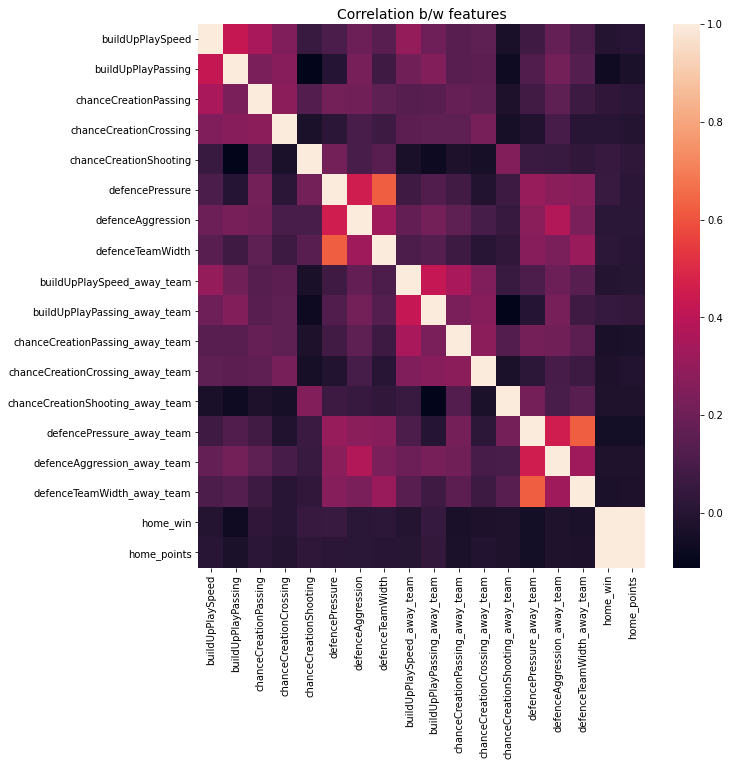

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
features_num=features.select_dtypes(include=numerics)
features_num[['home_win','home_points']]=match_team_and_attrs[['home_win','home_points']]
f, ax1 = plt.subplots(1, 1, figsize=(10,10))
corr = features_num.corr()
sns.heatmap(corr, annot_kws={'size':10}, ax=ax1)
ax1.set_title('Correlation b/w features', fontsize=14)
plt.show()

Classification Model for home points and home win 
Whole data 
predict odds ? 

Two models 1) predict home win

2) predict mean book odds on home win 

#Classifer

### TODO: Since data is time based should we stratify the test train on this instead of purley random?

### Set up Enviornment - run on GPU

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [ ]:
if(torch.cuda.is_available()):
    device = torch.device("cuda:0")
else:
  device = torch.device("cpu")
print(torch.cuda.get_device_name(0))

Tesla T4


In [ ]:
D_in = features_num.shape[1]-1
H1 = 300
H2 = 64
D_out = 3

#**TODO: check how many values are NaN, if number is small, we should just drop the data. If the number is large than we should either A) leave as 0 B) Fill with average value of that class**

In [ ]:
X = features_num.iloc[:,0:-1]
X = X.fillna(0)

# **TODO: Similar as above, but easier to state that if NaN than we can just state a draw.**

In [ ]:
y = features_num['home_win']
y = y.fillna(1)

In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state = 12)

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
epochs = 50
bs = 2500
lr = 1e-4
dtype = torch.float

In [ ]:
class teamData(Dataset):
  def __init__(self,X_data,y_data):
        self.X_data = X_data
        self.y_data = y_data
  def __getitem__(self, index):
      return self.X_data[index,:], self.y_data[index]
  def __len__(self):
      return len(self.X_data)

In [ ]:
train_dataset = teamData(torch.from_numpy(X_train).float(),torch.from_numpy(y_train).long())
val_dataset = teamData(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = teamData(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [ ]:
train_loader = DataLoader(dataset=train_dataset,batch_size=bs)
val_loader = DataLoader(dataset=val_dataset, batch_size=bs)
test_loader = DataLoader(dataset=test_dataset, batch_size=bs)

In [ ]:
class gameClassifier(nn.Module):
    def __init__(self):
        super(gameClassifier, self).__init__()
        
        self.layer_1 = nn.Linear(D_in, H1)
        self.layer_2 = nn.Linear(H1, H2)
        self.layer_out = nn.Linear(H2, D_out) 
        
        self.relu = nn.ReLU()
        #self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(H1)
        self.batchnorm2 = nn.BatchNorm1d(H2)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)  
        x = self.relu(x)
        #x = self.dropout(x)
                
        x = self.layer_out(x)
        
        return x

In [ ]:
model = gameClassifier()
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [ ]:
trainLossArr = []
valLossArr = [] 
trainAccArr = []
valAccArr = []
for e in tqdm(range(1, epochs+1)):
    # TRAINING of model
    train_epoch_loss = 0
    total = 0
    correct = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device) #send batches to device
        y_train_pred = model(X_train_batch) #use model to classify
        train_loss = criterion(y_train_pred, y_train_batch) #compute loss
        train_loss.backward() #compute gradient
        optimizer.step() 
        train_epoch_loss += train_loss.item()
        #print(train_loss.item())
        _, y_train_pred_tag = torch.max(y_train_pred.data,dim=1) #take maximum activation and use this as the predicted value
        y_train_batch.data
        correct_tag = y_train_batch.data #obtain the correct value
        total += y_train_batch.size(0)
        correct += (y_train_pred_tag == correct_tag).sum().item()
    epochAcc = correct/total *100
    trainAccArr.append(epochAcc)
    trainLossArr.append(train_epoch_loss/total)
    print("TRAIN: Epoch: {}, Class: {}, Prediction: {}, Accuracy: {}".format(e,correct_tag,y_train_pred_tag,epochAcc))
        # VALIDATION of model
    with torch.no_grad():
        val_epoch_loss = 0
        total = 0
        correct = 0
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_epoch_loss += val_loss.item()
            _, y_val_pred_tag = torch.max(y_val_pred.data,dim=1)
            correct_val = y_val_batch.data
            total += y_val_batch.size(0)
            correct += (y_val_pred_tag == correct_val).sum().item()
        valAcc = correct/total*100
        valAccArr.append(valAcc)
        valLossArr.append(val_epoch_loss/total)
        print("VALIDATE: Class: {}, Prediction: {}, Accuracy: {}".format(correct_val,y_val_pred_tag,valAcc))

TRAIN: Epoch: 1, Class: tensor([2, 2, 0,  ..., 1, 0, 0], device='cuda:0'), Prediction: tensor([0, 0, 2,  ..., 0, 1, 0], device='cuda:0'), Accuracy: 32.084809971892945
VALIDATE: Class: tensor([2, 0, 2,  ..., 1, 1, 1], device='cuda:0'), Prediction: tensor([0, 0, 0,  ..., 2, 0, 0], device='cuda:0'), Accuracy: 29.24683892248488
TRAIN: Epoch: 2, Class: tensor([2, 2, 0,  ..., 1, 0, 0], device='cuda:0'), Prediction: tensor([0, 0, 2,  ..., 0, 1, 0], device='cuda:0'), Accuracy: 36.82634730538922
VALIDATE: Class: tensor([2, 0, 2,  ..., 1, 1, 1], device='cuda:0'), Prediction: tensor([0, 0, 0,  ..., 2, 0, 0], device='cuda:0'), Accuracy: 29.576690489279823
TRAIN: Epoch: 3, Class: tensor([2, 2, 0,  ..., 1, 0, 0], device='cuda:0'), Prediction: tensor([0, 0, 0,  ..., 0, 1, 0], device='cuda:0'), Accuracy: 46.126115116705364
VALIDATE: Class: tensor([2, 0, 2,  ..., 1, 1, 1], device='cuda:0'), Prediction: tensor([2, 0, 0,  ..., 2, 0, 0], device='cuda:0'), Accuracy: 33.974711379879054
TRAIN: Epoch: 4, Clas

[0.0004769654433068503, 0.0004627142881365229, 0.00043592859229379537, 0.00040008760483387583, 0.00035991592802308556, 0.0003200966637655792, 0.00028398628632858857, 0.0002531476676660748, 0.00022766764714929683, 0.0002068304518797892, 0.0001896656762849989, 0.00017524730142369388, 0.00016283812316606437, 0.00015188930240919198, 0.0001420241600870139, 0.0001329628519188523, 0.00012450971252889398, 0.00011652348043865291, 0.00010890483703238012, 0.0001015846092733299, 9.451979994555346e-05, 8.7687429065709e-05, 8.107412692519516e-05, 7.469481198461076e-05, 6.856327186976291e-05, 6.269878358082245e-05, 5.712489433951706e-05, 5.18627594972056e-05, 4.692778599505522e-05, 4.2327830949681e-05, 3.8059979411335775e-05, 3.41171395344532e-05, 3.049487037966366e-05, 2.7184216090509072e-05, 2.4178492040312494e-05, 2.1458583297013335e-05, 1.901176273385747e-05, 1.6821485973797175e-05, 1.4866688942597488e-05, 1.3127370568937652e-05, 1.1580731602733677e-05, 1.019837552588012e-05, 8.962984723449263e-0

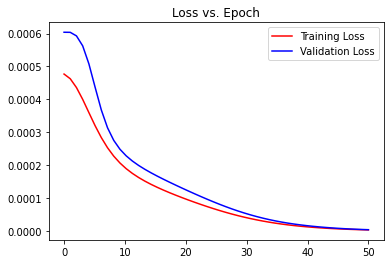

In [ ]:
ep1 = np.linspace(0,epochs,len(trainLossArr))
print(trainLossArr)
ep2 = np.linspace(0,epochs,len(valLossArr))
plt.clf()
plt.plot(ep1,trainLossArr,'r-',label="Training Loss")
plt.plot(ep2,valLossArr,'b-',label="Validation Loss")
plt.title("Loss vs. Epoch")
plt.legend(loc="best")
plt.show()

In [ ]:
#Test the data on the excluded dataset
y_pred_list = []
X_test_list = []
y_pred = []
numcorrect = 0
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _,y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy().astype(int))


for arr in y_pred_list:
  for el in arr:
    y_pred.append(el)

for i in range(len(y_test)):
  if y_test[i] == y_pred[i]:
          numcorrect += 1
accuracy = numcorrect/len(y_test) *100

print("Acccuracy: {} %".format(accuracy))

Acccuracy: 100.0 %


# Cross Validation


### Since this is in the same notebook, completley reload all variables to show that it is an independent test

In [ ]:
if(torch.cuda.is_available()):
    device = torch.device("cuda:0")
else:
  device = torch.device("cpu")
print(torch.cuda.get_device_name(0))

Tesla T4


In [ ]:
X = features_num.iloc[:,0:-1]
X = X.fillna(0)

In [ ]:
y = features_num['home_win']
y = y.fillna(1)

In [ ]:
D_in = features_num.shape[1]-1
H1 = 300
H2 = 64
D_out = 3

In [ ]:
scaler = MinMaxScaler()
X_for_fold = scaler.fit_transform(X)
X_fold_non, y_fold_non = np.array(X_for_fold),np.array(y) #non shuffled
#create random shuffeler to permuatate both x and y data
shuffler = np.random.permutation(len(X_fold_non))
X_fold, y_fold = X_fold_non[shuffler],y_fold_non[shuffler] #shuffled

In [ ]:
epochs = 50
bs = 2500
lr = 1e-4
dtype = torch.float
total_fold = 10


In [ ]:
class teamData(Dataset):
  def __init__(self,X_data,y_data):
        self.X_data = X_data
        self.y_data = y_data
  def __getitem__(self, index):
      return self.X_data[index,:], self.y_data[index]
  def __len__(self):
      return len(self.X_data)

In [ ]:
fold_dataset = teamData(torch.from_numpy(X_fold).float(),torch.from_numpy(y_fold).long())

In [ ]:
class gameClassifier(nn.Module):
    def __init__(self):
        super(gameClassifier, self).__init__()
        
        self.layer_1 = nn.Linear(D_in, H1)
        self.layer_2 = nn.Linear(H1, H2)
        self.layer_out = nn.Linear(H2, D_out) 
        
        self.relu = nn.ReLU()
        #self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(H1)
        self.batchnorm2 = nn.BatchNorm1d(H2)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)  
        x = self.relu(x)
        #x = self.dropout(x)
                
        x = self.layer_out(x)
        
        return x

In [ ]:
fold_test_acc = []
fold_train_acc = []
train_score = []
test_score = []
total_size = len(y_fold) #size of dataset
fold_size = int(total_size * (1/total_fold)) #size of each fold dataset
for i in range(total_fold):
    train_left_low = 0 #create indexes to bound the lower training set folds
    train_left_high = i*fold_size
    test_low = train_left_high #create indexes to bound the holdout fold
    test_high = i*fold_size + fold_size 
    train_right_low = test_high #create indexes to bound upper training set folds
    train_right_high = total_size
    print("Fold: {}, Training At: ({},{}), ({},{}) Testing At: ({},{})".format(i,train_left_low,train_left_high,train_right_low,train_right_high,test_low,test_high))
    train_left_idx = list(range(train_left_low,train_left_high))
    train_right_idx = list(range(train_right_low,train_right_high))
    train_idx = train_left_idx + train_right_idx
    
    test_idx = list(range(test_low,test_high))
    
    train_dataset = torch.utils.data.dataset.Subset(fold_dataset,train_idx)
    test_dataset = torch.utils.data.dataset.Subset(fold_dataset,test_idx)
    
    print(len(train_dataset),len(test_dataset))
    
    train_fold_loader = torch.utils.data.DataLoader(train_dataset,batch_size=bs)
    test_fold_loader = torch.utils.data.DataLoader(test_dataset,batch_size=bs)
    model = gameClassifier()
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for e in tqdm(range(1, epochs+1)):
        trainAccArr = []
        trainLossArr = []
        train_epoch_loss = 0
        total = 0
        correct = 0
        model.train()
        for X_train_batch, y_train_batch in train_fold_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            y_train_pred = model(X_train_batch)
            train_loss = criterion(y_train_pred, y_train_batch)
            train_loss.backward()
            optimizer.step()
            train_epoch_loss += train_loss.item()
            _, y_train_pred_tag = torch.max(y_train_pred.data,dim=1)
            correct_tag = y_train_batch.data
            total += y_train_batch.size(0)
            correct += (y_train_pred_tag == correct_tag).sum().item()
        epochAcc = correct/total *100
        print("Train Acc: {}".format(epochAcc))
        trainAccArr.append(epochAcc)
        trainLossArr.append(train_epoch_loss/total)
        train_score.append(trainAccArr[0])
    with torch.no_grad():
        val_epoch_loss = 0
        total = 0
        correct = 0
        valAccArr = []
        valLossArr = []
        model.eval()
        for X_val_batch, y_val_batch in test_fold_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)
            _, y_val_pred_tag = torch.max(y_val_pred.data,dim=1)
            correct_val = y_val_batch.data
            total += y_val_batch.size(0)
            print(y_val_pred_tag,correct_val)
            correct += (y_val_pred_tag == correct_val).sum().item()
        valAcc = correct/total*100
        valAccArr.append(valAcc)
        print("Test Acc: {}".format(valAcc))
        valLossArr.append(val_epoch_loss/total)
        test_score.append(valAccArr[0])

for i in range(total_fold):
    l = i*10
    r = l+10
    
    sumTrain = sum(train_score[l:r])
    fold_train_acc.append(sumTrain/total_fold)

final_train_accuracy = sum(fold_train_acc)/total_fold
final_test_accuracy = sum(test_score)/total_fold
print("Cross Validation Results")
print("Training Accuracy: {}".format(final_train_accuracy))
print("Testing Accuracy: {}".format(final_test_accuracy))

Fold: 0, Training At: (0,0), (2597,25979) Testing At: (0,2597)
23382 2597


Train Acc: 48.05405867761526
Train Acc: 55.7266273201608
Train Acc: 68.18065178342314
Train Acc: 78.7229492772218
Train Acc: 83.73535198015567
Train Acc: 86.10897271405355
Train Acc: 87.44760927208965
Train Acc: 88.5082542126422
Train Acc: 89.48336327089214
Train Acc: 90.54828500555983
Train Acc: 91.58754597553673
Train Acc: 92.65246771020443
Train Acc: 93.93550594474382
Train Acc: 95.07740997348387
Train Acc: 96.11667094346078
Train Acc: 97.02335129586862
Train Acc: 97.73329911898041
Train Acc: 98.22085364810538
Train Acc: 98.68274741253956
Train Acc: 99.01206055940467
Train Acc: 99.20023950047045
Train Acc: 99.2900521768882
Train Acc: 99.36275767684543
Train Acc: 99.4397399709178
Train Acc: 99.49961508852964
Train Acc: 99.54665982379608
Train Acc: 99.59798135317766
Train Acc: 99.6450260884441
Train Acc: 99.6706868531349
Train Acc: 99.71773158840134
Train Acc: 99.74766914720725
Train Acc: 99.78616029424343
Train Acc: 99.80754426481909
Train Acc: 99.81609785304936
Train Acc: 99.8203746

Train Acc: 32.37105465742879
Train Acc: 41.0358395346848
Train Acc: 59.80668890599606
Train Acc: 78.39363613035668
Train Acc: 86.72055427251732
Train Acc: 88.08057480112907
Train Acc: 87.26798391925412
Train Acc: 86.37413394919169
Train Acc: 85.75827559661278
Train Acc: 85.7753827730733
Train Acc: 86.2928748610042
Train Acc: 87.22521597810281
Train Acc: 88.32435206569156
Train Acc: 89.72286374133948
Train Acc: 91.3095543580532
Train Acc: 92.61825335728338
Train Acc: 94.22205115045762
Train Acc: 95.62056282610556
Train Acc: 96.45881447267128
Train Acc: 97.34411085450347
Train Acc: 97.90437088358567
Train Acc: 98.32349670686853
Train Acc: 98.68274741253956
Train Acc: 98.93080147121718
Train Acc: 99.11470361816782
Train Acc: 99.25583782396716
Train Acc: 99.36703447096058
Train Acc: 99.4525703532632
Train Acc: 99.53810623556582
Train Acc: 99.58515097083226
Train Acc: 99.61508852963819
Train Acc: 99.66213326490463
Train Acc: 99.69207082371054
Train Acc: 99.73911555897699
Train Acc: 99.77760

Train Acc: 30.390898982122998
Train Acc: 39.12838935933624
Train Acc: 55.9575742023779
Train Acc: 73.90300230946882
Train Acc: 84.47523736207339
Train Acc: 87.69138653665213
Train Acc: 87.75981524249423
Train Acc: 87.89667265417843
Train Acc: 88.2345393892738
Train Acc: 88.67077238901719
Train Acc: 89.35505944743821
Train Acc: 90.41998118210589
Train Acc: 91.49345650500385
Train Acc: 92.76366435719784
Train Acc: 94.06380976819776
Train Acc: 95.20571379693781
Train Acc: 96.23642117868447
Train Acc: 97.0618424429048
Train Acc: 97.75040629544094
Train Acc: 98.24651441279617
Train Acc: 98.62714908904286
Train Acc: 98.89658711829613
Train Acc: 99.17885552989479
Train Acc: 99.31998973569412
Train Acc: 99.39269523565135
Train Acc: 99.46540073560858
Train Acc: 99.52955264733556
Train Acc: 99.576597382602
Train Acc: 99.59370455906253
Train Acc: 99.62791891198358
Train Acc: 99.6450260884441
Train Acc: 99.68351723548028
Train Acc: 99.70062441194081
Train Acc: 99.72200838251646
Train Acc: 99.72200

Train Acc: 23.308527927465573
Train Acc: 36.309982037464714
Train Acc: 59.98631425883158
Train Acc: 80.29253271747498
Train Acc: 87.25515353690874
Train Acc: 89.48336327089214
Train Acc: 91.09999144641176
Train Acc: 92.38302968095115
Train Acc: 93.5634248567274
Train Acc: 94.6967752972372
Train Acc: 95.62483962022068
Train Acc: 96.39038576682918
Train Acc: 97.0490120605594
Train Acc: 97.66487041313832
Train Acc: 98.15670173637841
Train Acc: 98.58865794200668
Train Acc: 98.94363185356258
Train Acc: 99.16602514754939
Train Acc: 99.29432897100334
Train Acc: 99.4397399709178
Train Acc: 99.51672226499016
Train Acc: 99.54238302968095
Train Acc: 99.58087417671713
Train Acc: 99.61508852963819
Train Acc: 99.65357967667437
Train Acc: 99.68779402959541
Train Acc: 99.70062441194081
Train Acc: 99.74339235309212
Train Acc: 99.77332991189805
Train Acc: 99.7947138824737
Train Acc: 99.84603541185527
Train Acc: 99.8631425883158
Train Acc: 99.90163373535198
Train Acc: 99.93584808827303
Train Acc: 99.9615

Train Acc: 29.82636215892567
Train Acc: 33.91070053887606
Train Acc: 48.31494311863827
Train Acc: 71.91001625181764
Train Acc: 89.14121974168164
Train Acc: 93.57197844495767
Train Acc: 92.00667179881961
Train Acc: 89.46625609443161
Train Acc: 87.6614489778462
Train Acc: 86.46822341972458
Train Acc: 85.84381147891541
Train Acc: 85.58720383200753
Train Acc: 85.75399880249765
Train Acc: 86.31853562569498
Train Acc: 87.1140193311094
Train Acc: 88.17038747754683
Train Acc: 89.37644341801386
Train Acc: 90.71507997604995
Train Acc: 91.9639038576683
Train Acc: 93.49927294500043
Train Acc: 94.81652553246087
Train Acc: 95.91138482593448
Train Acc: 96.84800273714824
Train Acc: 97.75040629544094
Train Acc: 98.32777350098367
Train Acc: 98.71268497134548
Train Acc: 98.96073903002309
Train Acc: 99.18740911812506
Train Acc: 99.26439141219741
Train Acc: 99.40124882388162
Train Acc: 99.48678470618424
Train Acc: 99.55949020614148
Train Acc: 99.64074929432897
Train Acc: 99.70062441194081
Train Acc: 99.764

Train Acc: 31.032418099392693
Train Acc: 39.78701565306646
Train Acc: 56.915576084167306
Train Acc: 74.68993242665299
Train Acc: 85.01839021469506
Train Acc: 88.5210845949876
Train Acc: 89.7100333589941
Train Acc: 90.57822256436575
Train Acc: 91.36942947566504
Train Acc: 92.10931485758276
Train Acc: 92.81926268069455
Train Acc: 93.61046959199383
Train Acc: 94.36318535625695
Train Acc: 95.07740997348387
Train Acc: 95.75314344367463
Train Acc: 96.39893935505944
Train Acc: 97.07039603113506
Train Acc: 97.6092720896416
Train Acc: 98.09254982465144
Train Acc: 98.5245060302797
Train Acc: 98.78966726541785
Train Acc: 98.96501582413822
Train Acc: 99.12325720639808
Train Acc: 99.30715935334872
Train Acc: 99.49106150029937
Train Acc: 99.64930288255923
Train Acc: 99.70917800017108
Train Acc: 99.76477632366777
Train Acc: 99.81609785304936
Train Acc: 99.82465144127963
Train Acc: 99.82465144127963
Train Acc: 99.82892823539474
Train Acc: 99.83320502950987
Train Acc: 99.83748182362501
Train Acc: 99.85

Train Acc: 39.38072021212899
Train Acc: 48.798220853648104
Train Acc: 63.01856128645967
Train Acc: 76.10127448464631
Train Acc: 82.69609101017878
Train Acc: 85.02694380292533
Train Acc: 86.43828586091865
Train Acc: 87.83679753656659
Train Acc: 89.1497733299119
Train Acc: 90.45847232914207
Train Acc: 91.65169788726371
Train Acc: 92.77221794542811
Train Acc: 93.8243092977504
Train Acc: 94.71815926781285
Train Acc: 95.53075014968779
Train Acc: 96.42032332563511
Train Acc: 97.14737832520743
Train Acc: 97.75040629544094
Train Acc: 98.31494311863827
Train Acc: 98.76828329484219
Train Acc: 99.1104268240527
Train Acc: 99.36275767684543
Train Acc: 99.55521341202635
Train Acc: 99.63647250021384
Train Acc: 99.7134547942862
Train Acc: 99.76477632366777
Train Acc: 99.8503122059704
Train Acc: 99.9187409118125
Train Acc: 99.96150885296382
Train Acc: 99.97433923530922
Train Acc: 99.99144641176973
Train Acc: 99.99144641176973
Train Acc: 100.0
Train Acc: 100.0
Train Acc: 100.0
Train Acc: 100.0
Train Acc

Train Acc: 46.88649388418442
Train Acc: 56.74450431956206
Train Acc: 69.35249337096913
Train Acc: 76.77700795483705
Train Acc: 80.33102386451117
Train Acc: 82.89710033358995
Train Acc: 85.14241724403388
Train Acc: 87.2081088016423
Train Acc: 89.00863912411256
Train Acc: 90.24463262338551
Train Acc: 91.55760841673082
Train Acc: 92.61397656316825
Train Acc: 93.64896073903002
Train Acc: 94.6839449148918
Train Acc: 95.65905397314172
Train Acc: 96.55290394320417
Train Acc: 97.35694123684885
Train Acc: 97.90009408947054
Train Acc: 98.35343426567445
Train Acc: 98.70840817723034
Train Acc: 98.96929261825336
Train Acc: 99.315712941579
Train Acc: 99.5081686767599
Train Acc: 99.60653494140792
Train Acc: 99.65357967667437
Train Acc: 99.67496364725002
Train Acc: 99.74339235309212
Train Acc: 99.76905311778292
Train Acc: 99.82037464716448
Train Acc: 99.84175861774014
Train Acc: 99.8503122059704
Train Acc: 99.89735694123685
Train Acc: 99.93157129415789
Train Acc: 99.97006244119409
Train Acc: 99.978616

Train Acc: 45.63339320845095
Train Acc: 55.40159096741083
Train Acc: 72.82525019245574
Train Acc: 85.14669403814901
Train Acc: 88.8760585065435
Train Acc: 90.74074074074075
Train Acc: 92.15208279873407
Train Acc: 93.28543323924386
Train Acc: 94.13651526815498
Train Acc: 95.17577623813189
Train Acc: 95.96270635531606
Train Acc: 96.68120776665812
Train Acc: 97.25857497220083
Train Acc: 97.7033615601745
Train Acc: 98.10538020699684
Train Acc: 98.46035411855273
Train Acc: 98.64853305961852
Train Acc: 98.85381917714481
Train Acc: 99.03344452998033
Train Acc: 99.18740911812506
Train Acc: 99.33709691215465
Train Acc: 99.42690958857241
Train Acc: 99.48678470618424
Train Acc: 99.53810623556582
Train Acc: 99.61936532375331
Train Acc: 99.66213326490463
Train Acc: 99.7262851766316
Train Acc: 99.76905311778292
Train Acc: 99.81609785304936
Train Acc: 99.8631425883158
Train Acc: 99.90163373535198
Train Acc: 99.92301770592763
Train Acc: 99.94440167650329
Train Acc: 99.96150885296382
Train Acc: 99.9657

Train Acc: 33.307672568642545
Train Acc: 44.88067744418784
Train Acc: 65.52048584381149
Train Acc: 79.15062868873493
Train Acc: 83.68830724488923
Train Acc: 84.97134547942862
Train Acc: 85.89513300829698
Train Acc: 87.10974253699428
Train Acc: 88.43127191856985
Train Acc: 89.82978359421777
Train Acc: 91.36515268154992
Train Acc: 92.75083397485245
Train Acc: 94.06380976819776
Train Acc: 95.34257120862202
Train Acc: 96.48019844324695
Train Acc: 97.32700367804293
Train Acc: 97.9642460011975
Train Acc: 98.468907706783
Train Acc: 98.84526558891456
Train Acc: 99.11470361816782
Train Acc: 99.32426652980925
Train Acc: 99.43118638268754
Train Acc: 99.52527585322044
Train Acc: 99.58087417671713
Train Acc: 99.6706868531349
Train Acc: 99.7262851766316
Train Acc: 99.77760670601317
Train Acc: 99.82892823539474
Train Acc: 99.85458900008554
Train Acc: 99.8759729706612
Train Acc: 99.89308014712172
Train Acc: 99.91018732358225
Train Acc: 99.9059105294671
Train Acc: 99.91018732358225
Train Acc: 99.918740

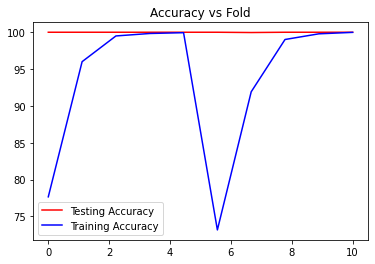

In [ ]:
testAcc = np.linspace(0,total_fold,len(test_score))
trainAcc = np.linspace(0,total_fold,len(fold_train_acc))
plt.clf()
plt.plot(testAcc,test_score,'r-',label="Testing Accuracy")
plt.plot(trainAcc,fold_train_acc,'b-',label = "Training Accuracy")
plt.legend(loc="best")
plt.title("Accuracy vs Fold")
plt.show()